In [72]:
#importing necessary laibraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [37]:
data=pd.read_csv('TRAIN.csv')

In [38]:
#data preprocessing

data.rename(columns={'#Order': 'Order'}, inplace=True)
data['Date']=pd.to_datetime(data['Date'])
data['Discount']=data['Discount'].map({"Yes":1,"No":0}) 
data_encoded = pd.get_dummies(data, columns=['Store_Type', 'Location_Type', 'Region_Code'])  #one hot encoding

In [39]:
data_encoded.head()

,ID,Store_id,Date,Holiday,Discount,Order,Sales,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,T1000001,1,2018-01-01,1,1,9,7011.84,1,0,0,0,0,0,1,0,0,1,0,0,0
1,T1000002,253,2018-01-01,1,1,60,51789.12,0,0,0,1,0,1,0,0,0,1,0,0,0
2,T1000003,252,2018-01-01,1,1,42,36868.20,0,0,1,0,0,1,0,0,0,1,0,0,0
3,T1000004,251,2018-01-01,1,1,23,19715.16,0,1,0,0,0,0,1,0,0,1,0,0,0
4,T1000005,250,2018-01-01,1,1,62,45614.52,0,1,0,0,0,0,1,0,0,0,0,0,1


In [40]:
# creating new time related features.

data_encoded['Year']=data_encoded['Date'].dt.year
data_encoded['Month']=data_encoded['Date'].dt.month
data_encoded['DayOfWeek']=data_encoded['Date'].dt.day_of_week
data_encoded['Week']=data['Date'].dt.isocalendar().week
data_encoded['Day']=data_encoded['Date'].dt.day

In [41]:
data_encoded.groupby('Date')['Store_id'].count()

Date
2018-01-01    365
2018-01-02    365
2018-01-03    365
2018-01-04    365
2018-01-05    365
             ... 
2019-05-27    365
2019-05-28    365
2019-05-29    365
2019-05-30    365
2019-05-31    365
Name: Store_id, Length: 516, dtype: int64

- so we are having sales data of 365 stores for each day
- to do time series forcasting we will aggregate this daily sales data of stores

In [42]:
# setting date as index of our datset

data_encoded.set_index(data_encoded['Date'],inplace=True)

In [43]:
# removing unneccessary columns

data_encoded.drop(columns=['ID','Date'],inplace=True)
data_encoded.head()

,Store_id,Holiday,Discount,Order,Sales,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,...,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Year,Month,DayOfWeek,Week,Day
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,1,9,7011.84,1,0,0,0,0,...,0,1,0,0,0,2018,1,0,1,1
2018-01-01,253,1,1,60,51789.12,0,0,0,1,0,...,0,1,0,0,0,2018,1,0,1,1
2018-01-01,252,1,1,42,36868.20,0,0,1,0,0,...,0,1,0,0,0,2018,1,0,1,1
2018-01-01,251,1,1,23,19715.16,0,1,0,0,0,...,0,1,0,0,0,2018,1,0,1,1
2018-01-01,250,1,1,62,45614.52,0,1,0,0,0,...,0,0,0,0,1,2018,1,0,1,1


In [44]:
# hear we are aggreagating the data. as we have 365 stores data for each day. 
# one row - one date

daily_agg = data_encoded.resample('D').agg({
    'Sales': 'sum',                                                       
    'Holiday': 'mean',                
    'Discount': 'sum',              
    'Order': 'sum',                  
    'Store_Type_S1': 'sum',          
    'Store_Type_S2': 'sum',
    'Store_Type_S3': 'sum',
    'Store_Type_S4': 'sum',
    'Location_Type_L1': 'sum',       
    'Location_Type_L2': 'sum',
    'Location_Type_L3': 'sum',
    'Location_Type_L4': 'sum',
    'Location_Type_L5': 'sum',
    'Region_Code_R1': 'sum',         
    'Region_Code_R2': 'sum',
    'Region_Code_R3': 'sum',
    'Region_Code_R4': 'sum',
    'Year': 'mean',                  
    'Month': 'mean',                  
    'DayOfWeek': 'mean',              
    'Week': 'mean',                   
    'Day': 'mean'                    
})

In [123]:
daily_agg.head()

,Sales,Holiday,Discount,Order,Year,Month,DayOfWeek,Week,Day,Sales_Lag_1,...,Sales_Lag_5,Sales_Lag_6,Sales_Lag_7,Sales_Rolling_Mean_7,Sales_Rolling_Std_7,Sales_CumSum,Sales_CumMean,DayOfYear,Quarter,Holiday_Discount
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,15345484.5,1.0,365,19666.0,2018,1,0,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,15345484.5,1.534548e+07,1,1,365.0
2018-01-02,19592415.0,0.0,365,25326.0,2018,1,1,1,2,15345484.5,...,0.0,0.0,0.0,0.0,0.0,34937899.5,1.746895e+07,2,1,0.0
2018-01-03,18652527.0,0.0,365,24047.0,2018,1,2,1,3,19592415.0,...,0.0,0.0,0.0,0.0,0.0,53590426.5,1.786348e+07,3,1,0.0
2018-01-04,19956267.0,0.0,364,25584.0,2018,1,3,1,4,18652527.0,...,0.0,0.0,0.0,0.0,0.0,73546693.5,1.838667e+07,4,1,0.0
2018-01-05,22902651.0,0.0,364,28436.0,2018,1,4,1,5,19956267.0,...,0.0,0.0,0.0,0.0,0.0,96449344.5,1.928987e+07,5,1,0.0


In [46]:
# this column has same values in each rows no variability so we will drop them

daily_agg.drop(columns=['Store_Type_S1',
       'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4'],inplace=True)

In [47]:
daily_agg.head()

,Sales,Holiday,Discount,Order,Year,Month,DayOfWeek,Week,Day
Date,,,,,,,,,
2018-01-01,15345484.5,1.0,365,19666,2018.0,1.0,0.0,1.0,1.0
2018-01-02,19592415.0,0.0,365,25326,2018.0,1.0,1.0,1.0,2.0
2018-01-03,18652527.0,0.0,365,24047,2018.0,1.0,2.0,1.0,3.0
2018-01-04,19956267.0,0.0,364,25584,2018.0,1.0,3.0,1.0,4.0
2018-01-05,22902651.0,0.0,364,28436,2018.0,1.0,4.0,1.0,5.0


In [48]:
daily_agg.isnull().sum()

Sales        0
Holiday      0
Discount     0
Order        0
Year         0
Month        0
DayOfWeek    0
Week         0
Day          0
dtype: int64

In [49]:
daily_agg.duplicated().sum()

0

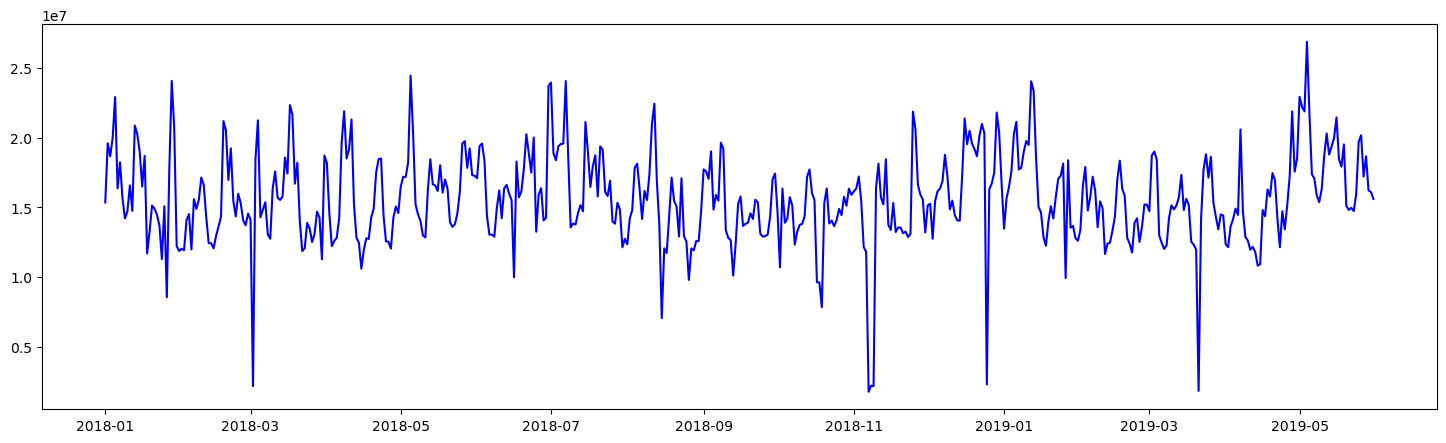

In [50]:
plt.figure(figsize=(18,5))
plt.plot(daily_agg['Sales'],color='blue')
plt.show()

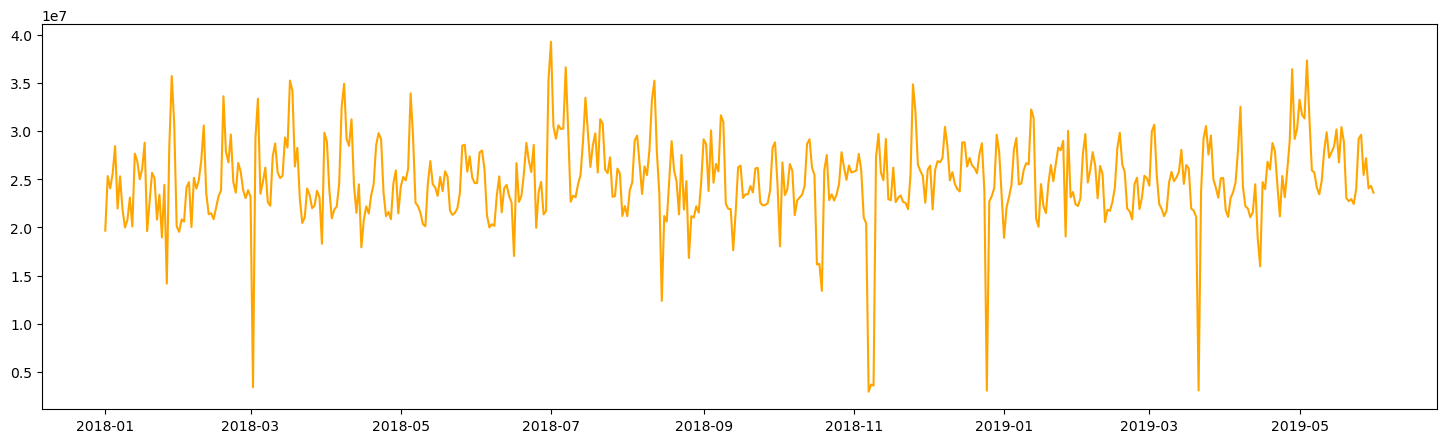

In [51]:
plt.figure(figsize=(18,5))
plt.plot(daily_agg.Order*1000,color='Orange')
plt.show()

- as we can see some extreme outliers are present we will clip them out

In [52]:
# outlier clipping

sales_lower_bound=daily_agg['Sales'].quantile(0.02)
sales_upper_bound=daily_agg['Sales'].quantile(0.995)

order_lower_bound=daily_agg['Order'].quantile(0.02)
order_upper_bound=daily_agg['Order'].quantile(0.995)

daily_agg.Sales=daily_agg.Sales.clip(lower=sales_lower_bound,upper=sales_upper_bound)

daily_agg.Order=daily_agg.Order.clip(lower=order_lower_bound,upper=order_upper_bound)

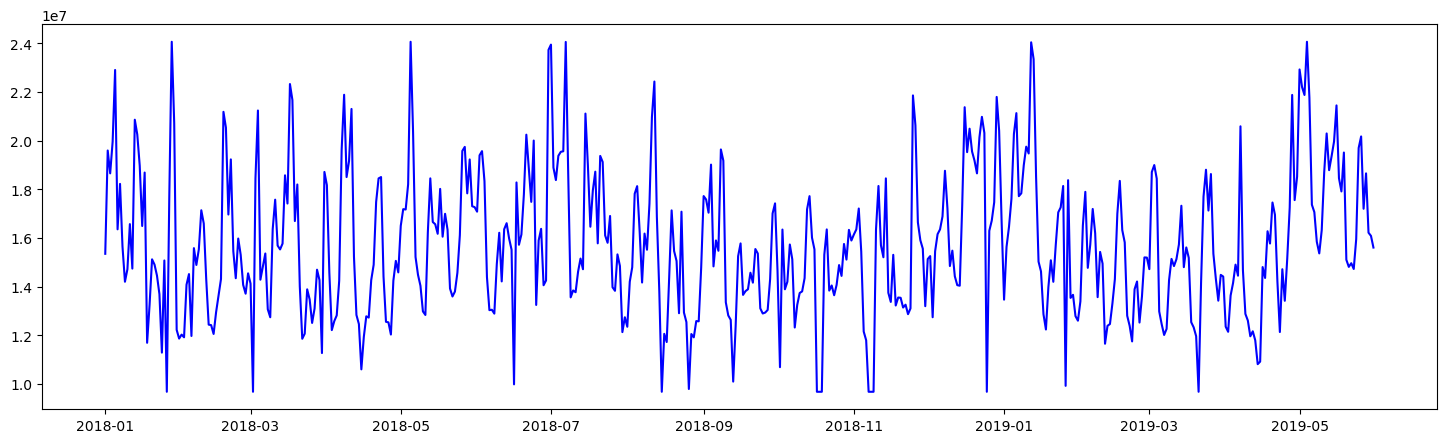

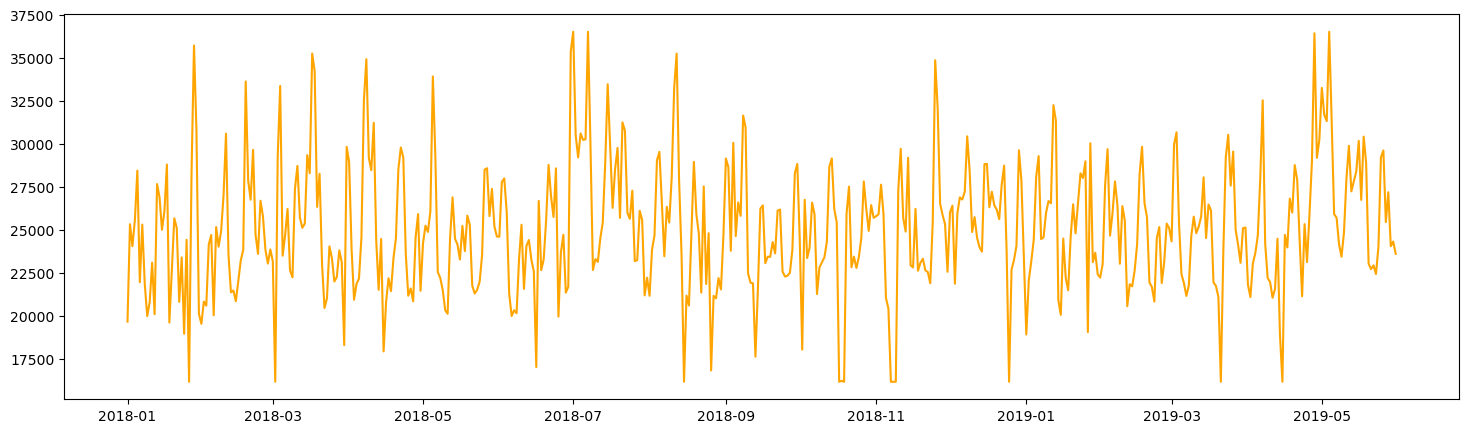

In [54]:
plt.figure(figsize=(18,5))
plt.plot(daily_agg['Sales'],color='blue')
plt.show()
plt.figure(figsize=(18,5))
plt.plot(daily_agg.Order,color='Orange')
plt.show()

In [55]:
# Dickey–Fuller test to test data is stationary or not 

def adf_test(dataset):
    pvalue = sm.tsa.stattools.adfuller(dataset)[1]
    if pvalue <= 0.05:
        print(f'pvalue:{pvalue} , Sequence is stationary')
        
    else:
        print(f'pvalue:{pvalue} , Sequence is not stationary')

adf_test(daily_agg.Sales)

pvalue:0.00872600813053441 , Sequence is stationary


In [56]:
adf_test(daily_agg.Order)

pvalue:0.0002250769890472867 , Sequence is stationary


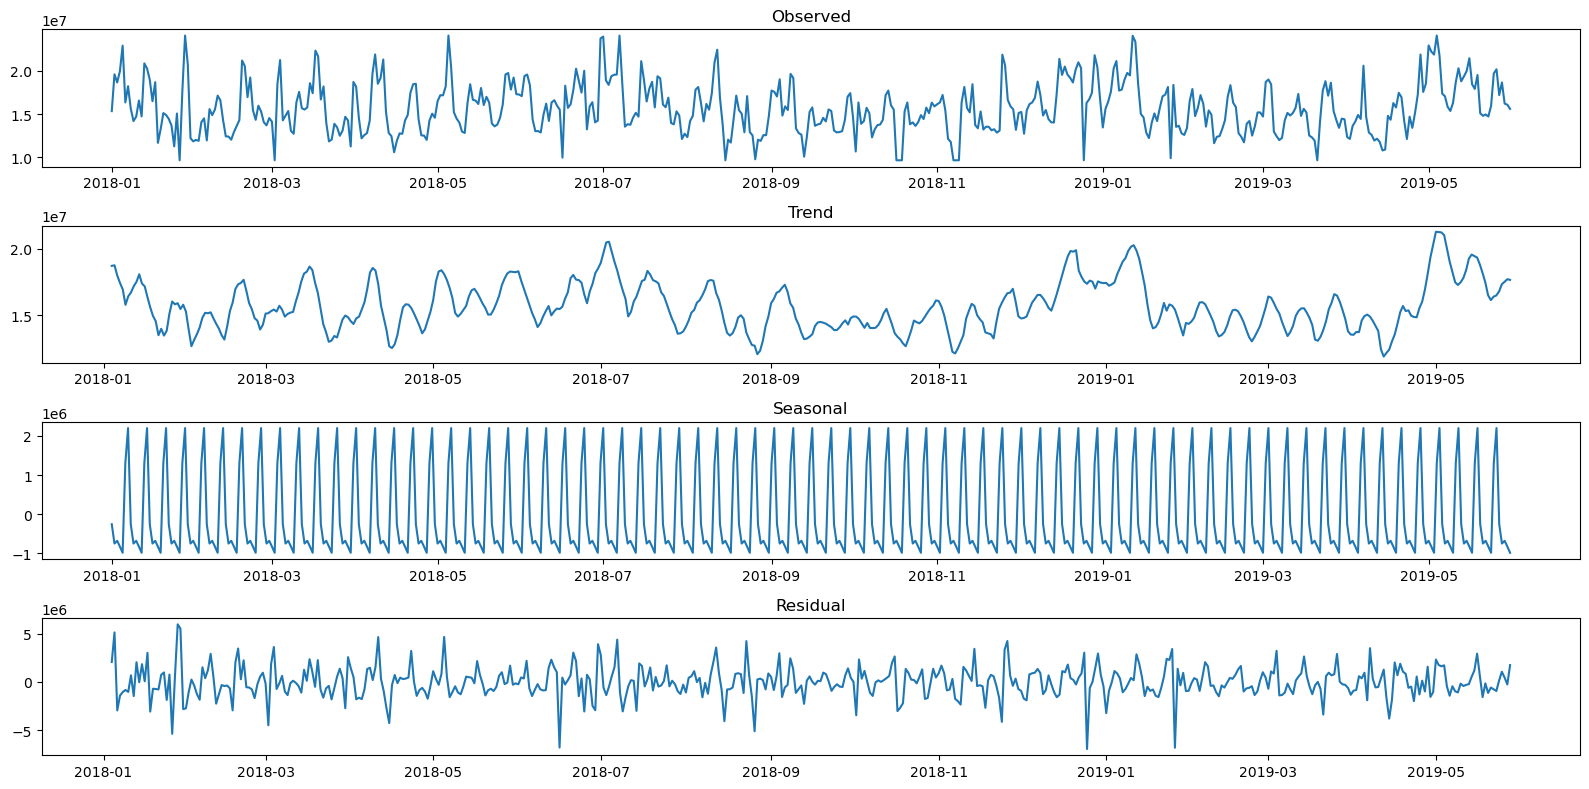

In [58]:
decomposition = sm.tsa.seasonal_decompose(daily_agg.Sales, model='additive')

# Plot the decomposition
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# no trend but seasonality is there

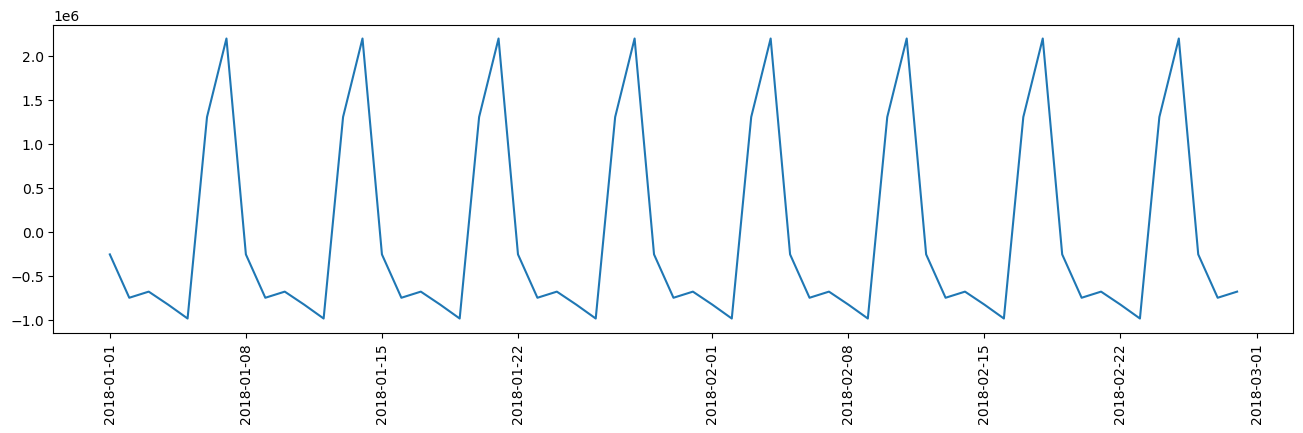

In [60]:
plt.figure(figsize=(16,4))
# Assuming the index of decomposition.seasonal is of datetime type
plt.plot(decomposition.seasonal['2018-01-01':'2018-02-28'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# visually we can clearly see that data has weekly seasonality period

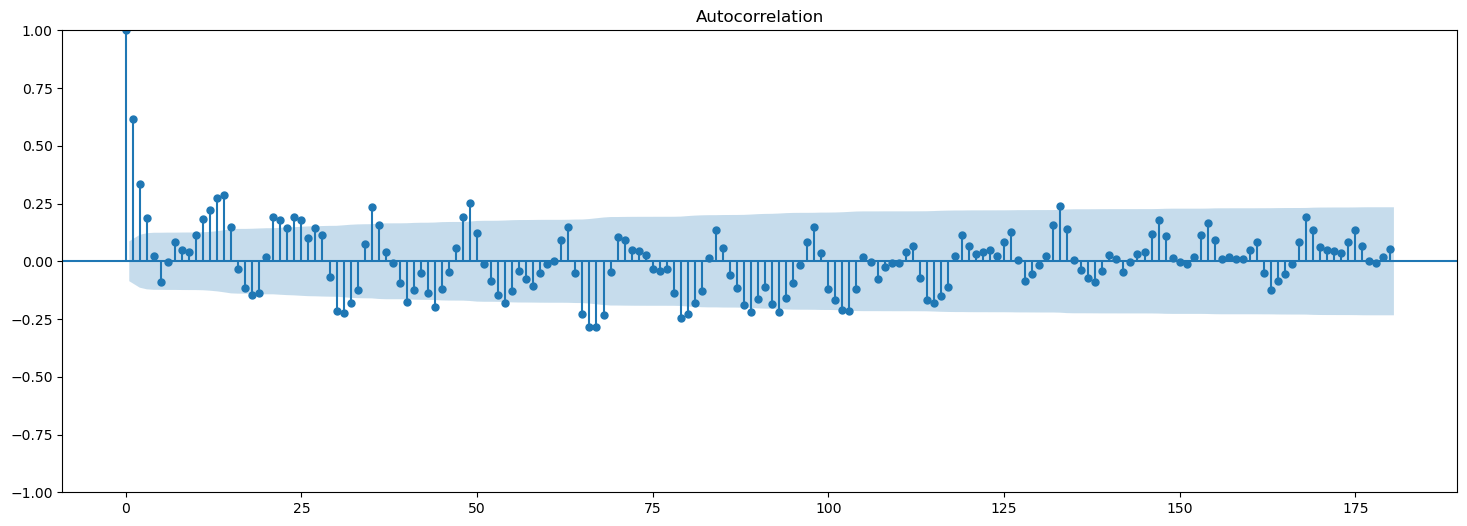

In [67]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(daily_agg['Sales'], ax=ax, lags=180)
plt.show()


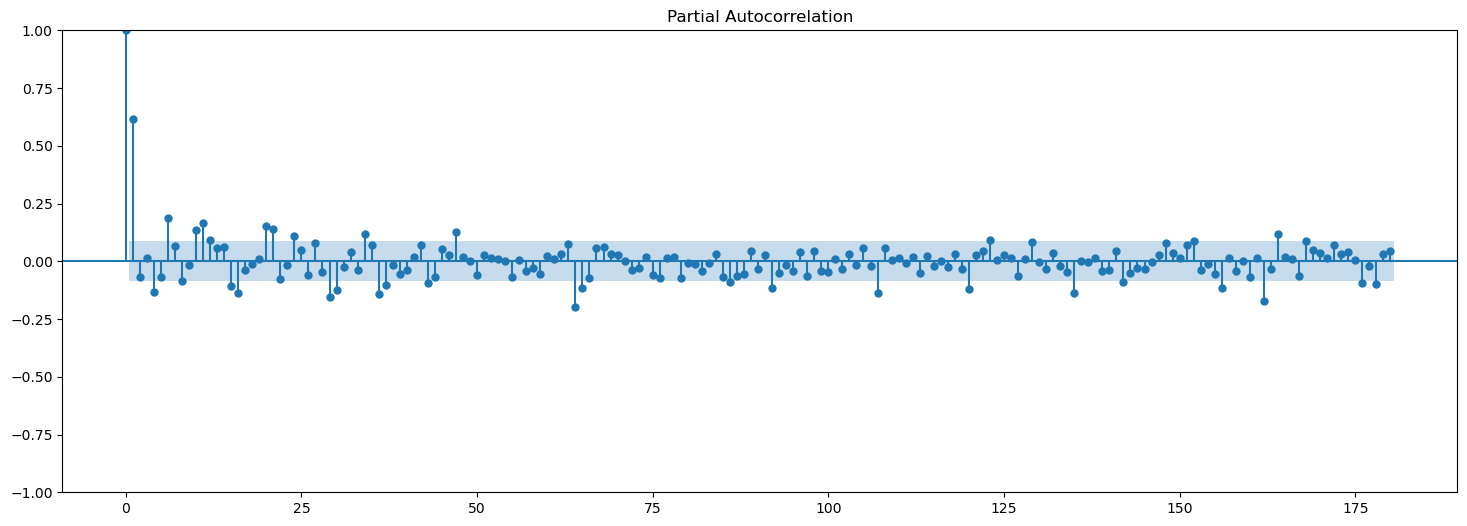

In [66]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_pacf(daily_agg['Sales'], ax=ax, lags=180)
plt.show()

- ACF: Helps to identify the moving average (MA) terms. (q=3)
- PACF: Helps to identify the autoregressive (AR) terms. (p=1)

In [70]:
daily_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 2018-01-01 to 2019-05-31
Freq: D
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sales      516 non-null    float64
 1   Holiday    516 non-null    float64
 2   Discount   516 non-null    int64  
 3   Order      516 non-null    float64
 4   Year       516 non-null    float64
 5   Month      516 non-null    float64
 6   DayOfWeek  516 non-null    float64
 7   Week       516 non-null    Float64
 8   Day        516 non-null    float64
dtypes: Float64(1), float64(7), int64(1)
memory usage: 40.8 KB


In [108]:

daily_agg = daily_agg.astype({
    'Holiday': 'float64',
    'Discount': 'int64',
    'Year': 'int64',
    'Month': 'int64',
    'DayOfWeek': 'int64',
    'Week': 'int64',
    'Day': 'int64'
})

test_exog = test_exog.astype({
    'Holiday': 'float64',
    'Discount': 'int64',
    'Year': 'int64',
    'Month': 'int64',
    'DayOfWeek': 'int64',
    'Week': 'int64',
    'Day': 'int64'
})

In [109]:
# Train-Test Split
train_data = daily_agg.loc[:'2019-03-01']
test_data = daily_agg.loc['2019-03-02':]

In [110]:
# SARIMA Model
sarima_model = SARIMAX(train_data['Sales'], order=(1, 0, 3), seasonal_order=(1, 0, 3, 7))
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Model Evaluation
sarima_mae = mean_absolute_error(test_data['Sales'], sarima_pred)
sarima_mse = mean_squared_error(test_data['Sales'], sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_data['Sales'], sarima_pred)

print(f'SARIMA MAE: {sarima_mae}, MSE: {sarima_mse}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}')

SARIMA MAE: 2479870.738870742, MSE: 10029866446762.488, RMSE: 3166996.439335303, MAPE: 0.14864125640930748


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


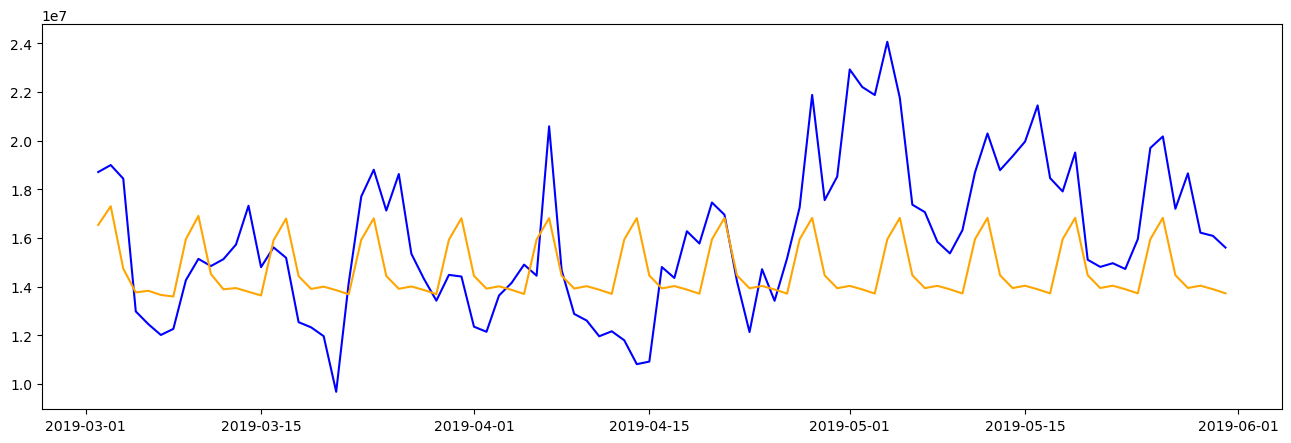

In [111]:
plt.figure(figsize=(16,5))
plt.plot(test_data['Sales'],color='blue')
plt.plot(sarima_pred,color='orange')
plt.show()

In [112]:
# Ensure the exogenous variables are aligned correctly
train_exog = train_data[['Holiday', 'Discount']]
test_exog = test_data[['Holiday', 'Discount']]

In [113]:
# SARIMA Model
sarima_model = SARIMAX(train_data['Sales'], order=(1, 0, 3), seasonal_order=(1, 0, 3, 7), exog=train_exog)
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)

# Model Evaluation
sarima_mae = mean_absolute_error(test_data['Sales'], sarima_pred)
sarima_mse = mean_squared_error(test_data['Sales'], sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_data['Sales'], sarima_pred)

print(f'SARIMA MAE: {sarima_mae}, MSE: {sarima_mse}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}')

SARIMA MAE: 5603808.403294856, MSE: 40058614625108.03, RMSE: 6329187.516980994, MAPE: 0.3673465092874405


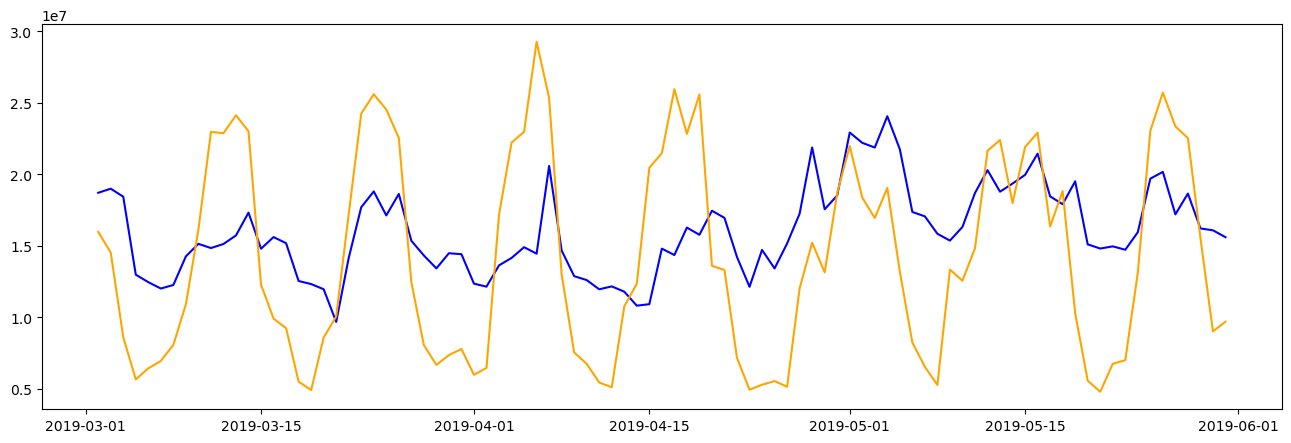

In [114]:
plt.figure(figsize=(16,5))
plt.plot(test_data['Sales'],color='blue')
plt.plot(sarima_pred,color='orange')
plt.show()

SARIMA MAE: 1843250.9878716446, MSE: 5580523270319.441, RMSE: 2362313.118602071, MAPE: 0.112159949641157


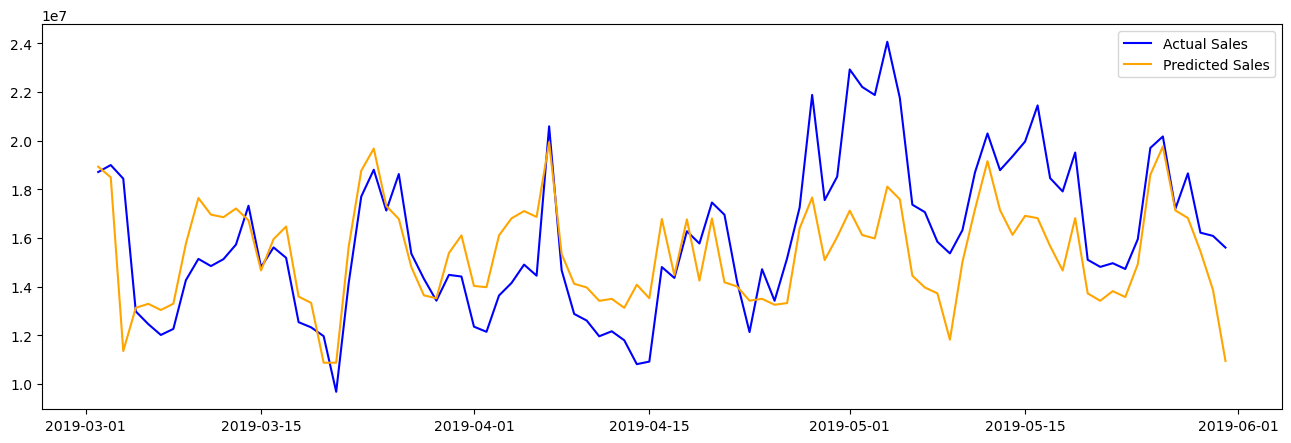

In [115]:

# Ensure all exogenous variables are filled and converted
train_exog = train_data[['Holiday', 'Discount', 'Year', 'Month', 'DayOfWeek', 'Week', 'Day']]
test_exog = test_data[['Holiday', 'Discount', 'Year', 'Month', 'DayOfWeek', 'Week', 'Day']]


# Convert train_data['Sales'] to numeric if not already
train_sales = train_data[['Sales']]
test_sales = test_data[['Sales']]

# SARIMA Model
sarima_model = SARIMAX(train_sales, order=(1, 0, 3), seasonal_order=(1, 0, 3, 7), exog=train_exog)
sarima_fit = sarima_model.fit(disp=False)

# Predict using the fitted model and the test exogenous variables
sarima_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)

# Model Evaluation
sarima_mae = mean_absolute_error(test_sales, sarima_pred)
sarima_mse = mean_squared_error(test_sales, sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_sales, sarima_pred)

print(f'SARIMA MAE: {sarima_mae}, MSE: {sarima_mse}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}')

# Plot the actual vs predicted sales
plt.figure(figsize=(16, 5))
plt.plot(test_sales.index, test_sales, color='blue', label='Actual Sales')
plt.plot(test_sales.index, sarima_pred, color='orange', label='Predicted Sales')
plt.legend()
plt.show()


In [119]:
for lag in range(1, 8):  # Lags from 1 to 7 days
    daily_agg[f'Sales_Lag_{lag}'] = daily_agg['Sales'].shift(lag)

# Creating Rolling Statistics Features
daily_agg['Sales_Rolling_Mean_7'] = daily_agg['Sales'].rolling(window=7).mean()
daily_agg['Sales_Rolling_Std_7'] = daily_agg['Sales'].rolling(window=7).std()

# Creating Cumulative Statistics Features
daily_agg['Sales_CumSum'] = daily_agg['Sales'].cumsum()
daily_agg['Sales_CumMean'] = daily_agg['Sales'].expanding().mean()

# Creating Time-based Features
daily_agg['DayOfYear'] = daily_agg.index.dayofyear
daily_agg['Quarter'] = daily_agg.index.quarter

# Creating Interaction Terms
daily_agg['Holiday_Discount'] = daily_agg['Holiday'] * daily_agg['Discount']

# Fill NaN values created by lagging and rolling calculations
daily_agg = daily_agg.fillna(0)

In [120]:
daily_agg.head()

,Sales,Holiday,Discount,Order,Year,Month,DayOfWeek,Week,Day,Sales_Lag_1,...,Sales_Lag_5,Sales_Lag_6,Sales_Lag_7,Sales_Rolling_Mean_7,Sales_Rolling_Std_7,Sales_CumSum,Sales_CumMean,DayOfYear,Quarter,Holiday_Discount
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,15345484.5,1.0,365,19666.0,2018,1,0,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,15345484.5,1.534548e+07,1,1,365.0
2018-01-02,19592415.0,0.0,365,25326.0,2018,1,1,1,2,15345484.5,...,0.0,0.0,0.0,0.0,0.0,34937899.5,1.746895e+07,2,1,0.0
2018-01-03,18652527.0,0.0,365,24047.0,2018,1,2,1,3,19592415.0,...,0.0,0.0,0.0,0.0,0.0,53590426.5,1.786348e+07,3,1,0.0
2018-01-04,19956267.0,0.0,364,25584.0,2018,1,3,1,4,18652527.0,...,0.0,0.0,0.0,0.0,0.0,73546693.5,1.838667e+07,4,1,0.0
2018-01-05,22902651.0,0.0,364,28436.0,2018,1,4,1,5,19956267.0,...,0.0,0.0,0.0,0.0,0.0,96449344.5,1.928987e+07,5,1,0.0


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MAE: 1109914.4839624956, MSE: 1903394244793.6877, RMSE: 1379635.5478145988, MAPE: 0.0706397229419312


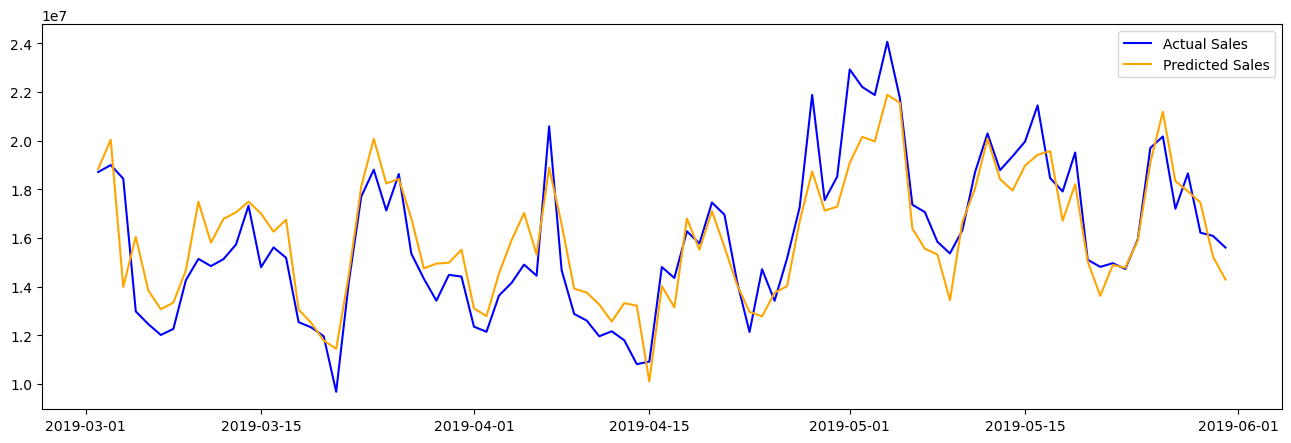

In [122]:
# Train-Test Split
train_data = daily_agg.loc['2018-01-02':'2019-03-01']
test_data = daily_agg.loc['2019-03-02':]

# Ensure the exogenous variables are aligned correctly
exog_features = ['Holiday', 'Discount', 'Year', 'Month', 'DayOfWeek', 'Week', 'Day',
                 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_5', 'Sales_Lag_6', 'Sales_Lag_7',
                 'Sales_Rolling_Mean_7', 'Sales_Rolling_Std_7', 'Sales_CumSum', 'Sales_CumMean',
                 'DayOfYear', 'Quarter', 'Holiday_Discount']
train_exog = train_data[exog_features]
test_exog = test_data[exog_features]


# Convert train_data['Sales'] to numeric if not already
train_sales = train_data[['Sales']]
test_sales = test_data[['Sales']]

# SARIMA Model
sarima_model = SARIMAX(train_sales, order=(1, 0, 3), seasonal_order=(1, 0, 3, 7), exog=train_exog)
sarima_fit = sarima_model.fit(disp=False)

# Predict using the fitted model and the test exogenous variables
sarima_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)

# Model Evaluation
sarima_mae = mean_absolute_error(test_sales, sarima_pred)
sarima_mse = mean_squared_error(test_sales, sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_sales, sarima_pred)

print(f'SARIMA MAE: {sarima_mae}, MSE: {sarima_mse}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}')

# Plot the actual vs predicted sales
plt.figure(figsize=(16, 5))
plt.plot(test_sales.index, test_sales, color='blue', label='Actual Sales')
plt.plot(test_sales.index, sarima_pred, color='orange', label='Predicted Sales')
plt.legend()
plt.show()